### Setting up FourRooms

In [10]:
from deep_rl.component.fourrooms_dynamic import *

/network/home/penmetss/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/network/home/penmetss/.conda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'plot in log scale')

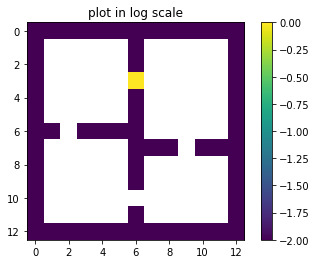

In [23]:
plt.imshow(np.log10(env.render_state())), plt.colorbar()
plt.title('plot in log scale')

[ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.    0.   -0.01  0.    0.    0.01  0.    0.    0.    0.
  0.    0.01  0.01  0.    0.    0.    0.    0.    0.01  0.    0.    0.
  0.    0.    0.01  0.01  0.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    0.    0.01  0.01  0.    0.    0.    0.    0.    0.01  0.
  0.    0.    0.    0.    0.01  0.01  0.    0.    0.    0.    0.    0.01
  0.    0.    0.    0.    0.    0.01  0.01  0.01  0.    0.01  0.01  0.01
  0.01  0.    0.    0.    0.    0.    0.01  0.01  0.    0.    0.    0.
  0.    0.01  0.01  0.01  0.    0.01  0.01  0.01  0.01  0.    0.    0.
  0.    0.    0.01  0.    0.    0.    0.    0.    0.01  0.01  0.    0.
  0.    0.    0.    0.01  0.    0.    0.    0.    0.    0.01  0.01  0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.01
  0.    0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.    0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01 

(<matplotlib.axes._subplots.AxesSubplot at 0x7fca00aa0668>,
 <matplotlib.image.AxesImage at 0x7fca00ac3be0>)

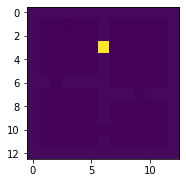

In [22]:
# env = DyFourRoomsMatrix()
state = env.reset()
print(state)
plt.subplot(121), plt.imshow(state.reshape((13,13)))
# action = env.action_space.sample()
# state, reward, done, info = env.step(action)
# print(reward, done, info)
# plt.subplot(122), plt.imshow(state.reshape((13,13))); plt.show()
# print(action)

In [9]:
env.observation_space

Box(169,)

### Run DQN on 4 rooms

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
select_device(0)

In [55]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [4]:
game = 'Dy-FourRoomsMatrix'
agent = dqn_feature(game=game)

here Dy-FourRoomsMatrix
here Dy-FourRoomsMatrix


2020-06-11 23:05:17,276 - root - INFO: steps 0, episodic_return_test -200.00(0.00)


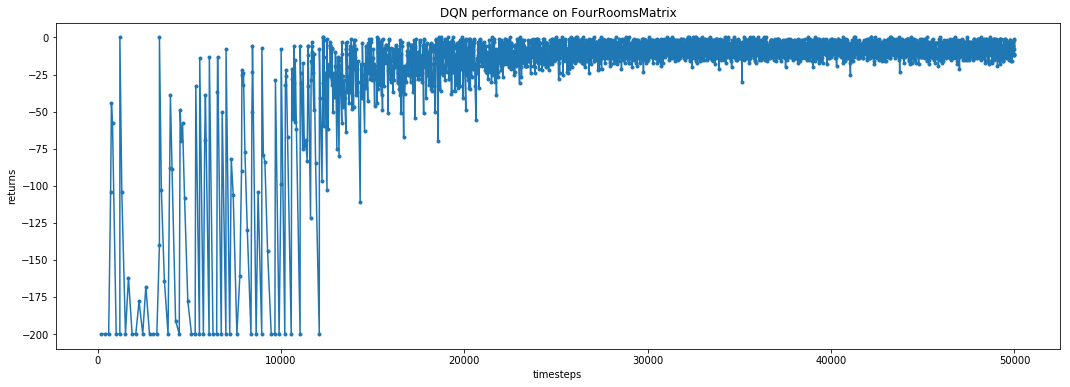

(Text(0.5,1,'DQN performance on FourRoomsMatrix'), None)

In [9]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

In [5]:
class SRNetCNN(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(1000,), gate=F.relu, config=1):
        """
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetCNN, self).__init__()
        self.body = body
        self.output_dim = output_dim
        self.width = int(np.sqrt(body.feature_dim))

        # CNN layers
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.fc_size = 128 * ((self.width - (3-1)*2) // 2) ** 2

        # FC layers
        dims = (self.fc_size,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, body.feature_dim)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)
        self.to(Config.DEVICE)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi

        # Convert to image
        psi = psi.view(phi.size(0), 1, self.width, self.width)

        # Conv layers
        psi = self.conv1(psi)
        psi = F.relu(psi)
        psi = self.conv2(psi)
        psi = F.relu(psi)
        psi = F.max_pool2d(psi, 2)
        psi = torch.flatten(psi, 1)

        # FC layers
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [6]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), 
                                         hidden_units=(2000,), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [38]:
avdsr2 = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[agent], choice=0)

2020-06-11 23:25:55,539 - root - INFO: steps 0, 279620266.67 steps/s
2020-06-11 23:25:57,836 - root - INFO: steps 1000, 435.84 steps/s
2020-06-11 23:26:00,144 - root - INFO: steps 2000, 433.46 steps/s
2020-06-11 23:26:02,422 - root - INFO: steps 3000, 439.33 steps/s
2020-06-11 23:26:04,742 - root - INFO: steps 4000, 431.60 steps/s
2020-06-11 23:26:07,078 - root - INFO: steps 5000, 428.75 steps/s
2020-06-11 23:26:09,396 - root - INFO: steps 6000, 431.74 steps/s
2020-06-11 23:26:11,708 - root - INFO: steps 7000, 432.61 steps/s
2020-06-11 23:26:13,997 - root - INFO: steps 8000, 437.03 steps/s
2020-06-11 23:26:16,321 - root - INFO: steps 9000, 430.48 steps/s
2020-06-11 23:26:18,652 - root - INFO: steps 10000, 429.48 steps/s
2020-06-11 23:26:20,948 - root - INFO: steps 11000, 435.73 steps/s
2020-06-11 23:26:23,237 - root - INFO: steps 12000, 437.07 steps/s
2020-06-11 23:26:25,564 - root - INFO: steps 13000, 429.93 steps/s
2020-06-11 23:26:27,860 - root - INFO: steps 14000, 435.61 steps/s
20

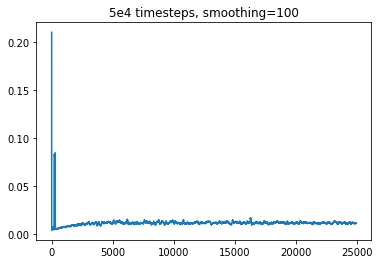

(Text(0.5, 1.0, '5e4 timesteps, smoothing=100'), None)

In [48]:
kernel = 100
plt.plot(convolve(avdsr2.loss_vec, kernel))
plt.title('5e4 timesteps, smoothing=' + str(kernel)), plt.show()
# plt.subplot(122), plt.plot(avdsr.retu)

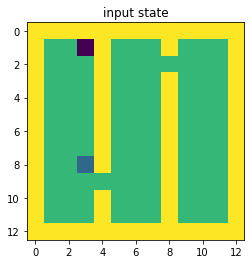

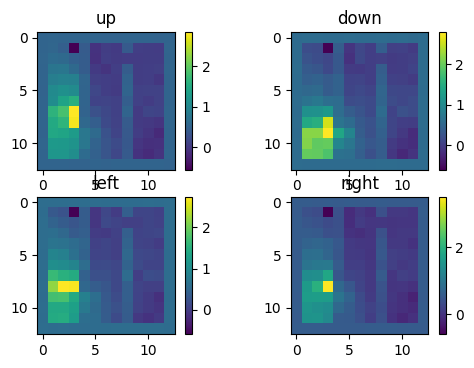

In [42]:
from deep_rl.component.fourrooms import FourRoomsMatrix
# env = DyFourRoomsMatrix()
state = env.reset()
state = env.reset()
env.step(env.action_space.sample())
env.step(env.action_space.sample())
env.step(env.action_space.sample())
state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [31]:
params_count(avdsr.network.psi2q)

169

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [49]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), 
                                         hidden_units=(2000,), config=1) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [50]:
def runNAgents(function, runs, store=True, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [56]:
# r_c1_a1 = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=avdsr2)
# r_c1 = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=avdsr)
r_dqn_base2 = runNAgents(dqn_feature, runs=3)

2020-06-11 23:45:49,026 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-06-11 23:45:55,380 - root - INFO: steps 5000, episodic_return_test -180.10(18.88)
2020-06-11 23:46:01,755 - root - INFO: steps 10000, episodic_return_test -141.40(28.31)
2020-06-11 23:46:07,871 - root - INFO: steps 15000, episodic_return_test -101.50(31.15)
2020-06-11 23:46:14,051 - root - INFO: steps 20000, episodic_return_test -141.00(28.50)
2020-06-11 23:46:20,042 - root - INFO: steps 25000, episodic_return_test -83.00(30.22)
2020-06-11 23:46:25,902 - root - INFO: steps 30000, episodic_return_test -26.90(18.26)
2020-06-11 23:46:31,708 - root - INFO: steps 35000, episodic_return_test -23.60(18.61)
2020-06-11 23:46:37,501 - root - INFO: steps 40000, episodic_return_test -7.10(1.06)
2020-06-11 23:46:43,471 - root - INFO: steps 45000, episodic_return_test -81.80(30.52)
2020-06-11 23:46:49,378 - root - INFO: steps 50000, episodic_return_test -65.90(27.77)
2020-06-11 23:46:50,004 - root - INFO: steps 0

In [67]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 1000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

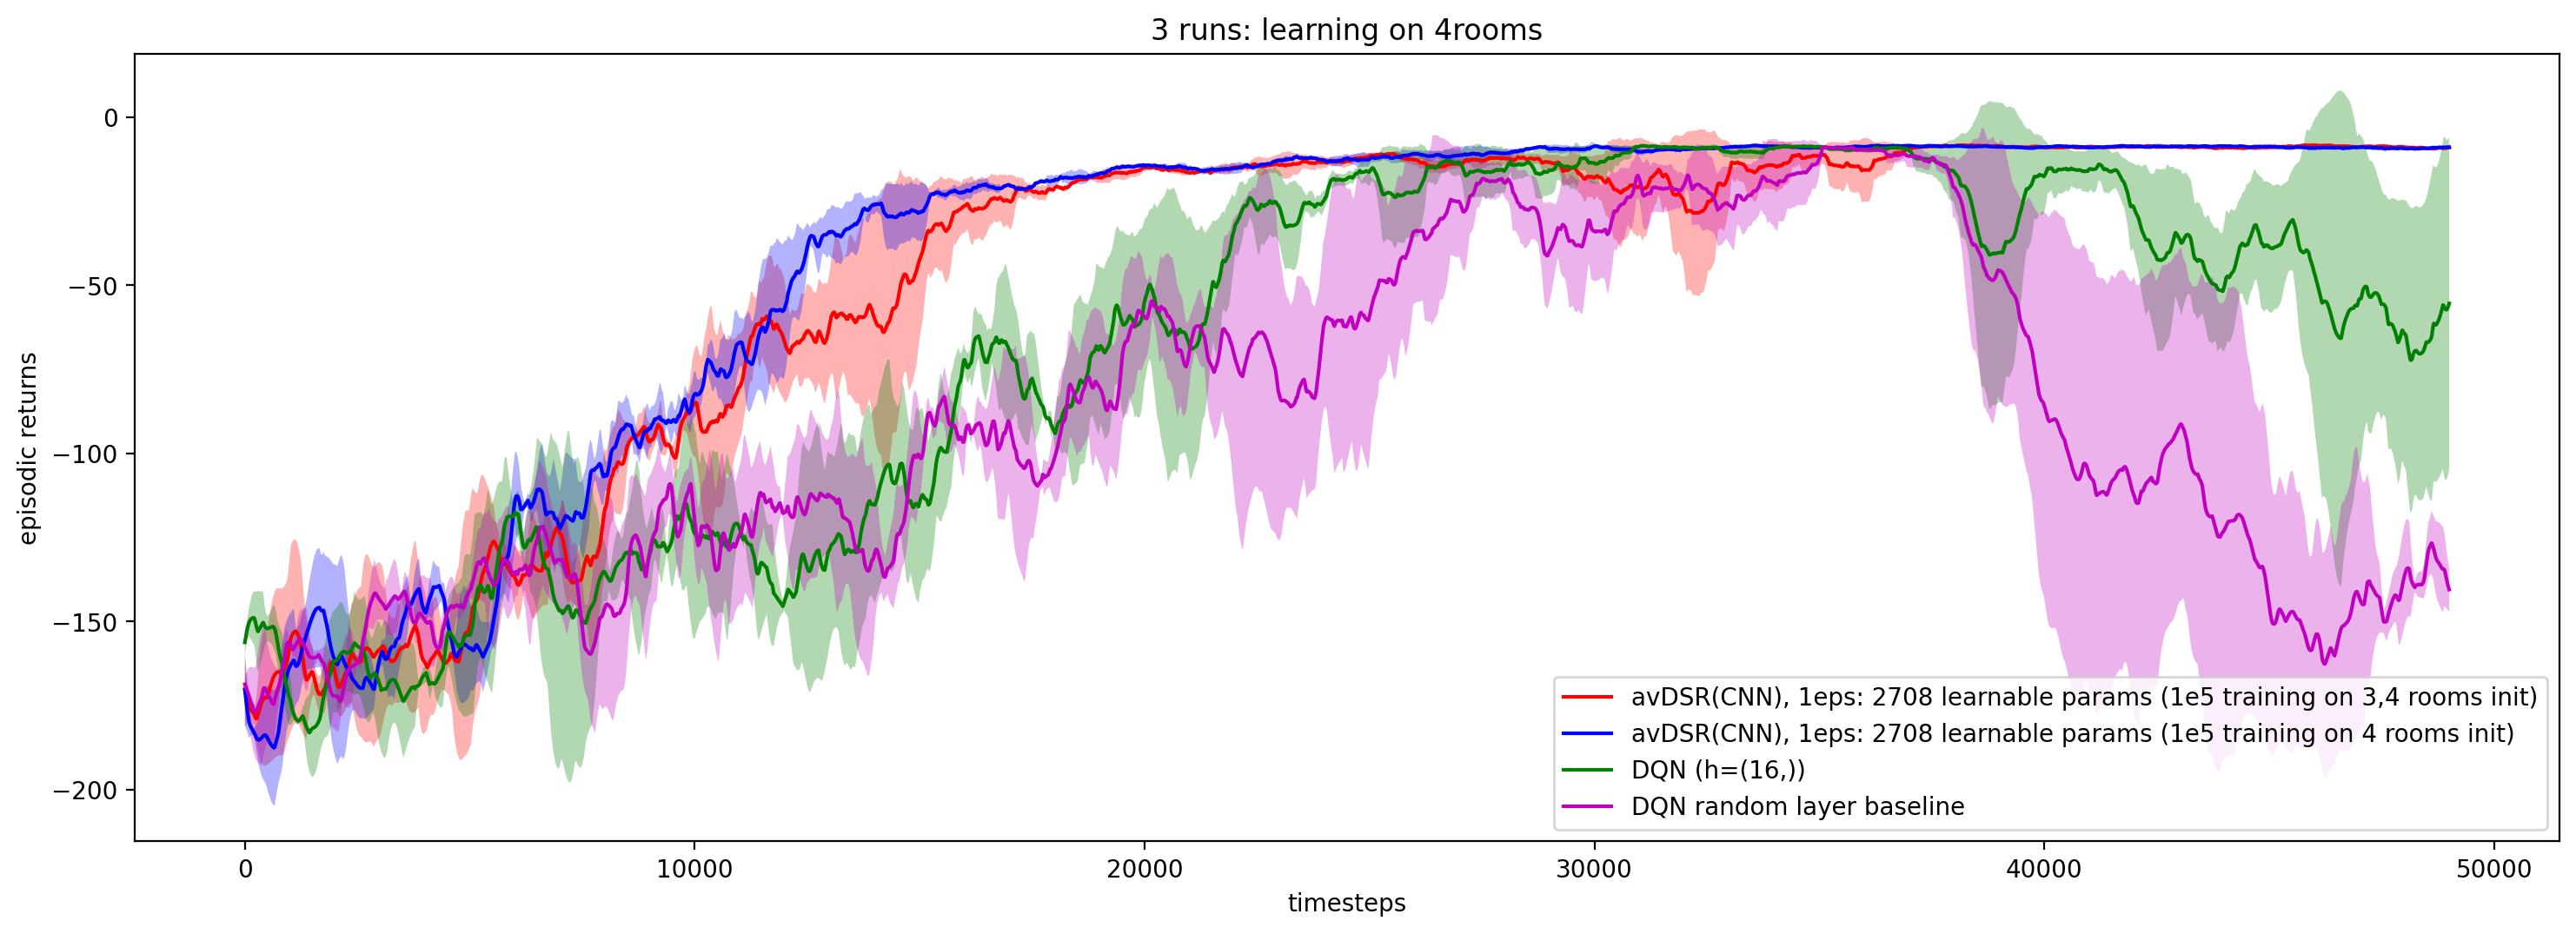

In [68]:
rewards_dict = {
               'avDSR(CNN), 1eps: 2708 learnable params (1e5 training on 3,4 rooms init)': r_c1[1:],
               'avDSR(CNN), 1eps: 2708 learnable params (1e5 training on 4 rooms init)': r_c1_a1[1:],
               'DQN (h=(16,))': r_dqn_base2[1:],
               'DQN random layer baseline': r_dqn_base
               }
# rewards_dict = {'avDSR, 1eps: 169 learnable params':r_dsr_rand,
#                 'avDSR, 1eps: 2708 learnable params':r_dsr_abs_rand[1:],
#                 'DQN, h=(676,): 117628 learnable params': r_dqn_base,
#                'DQN, h=(16,): 2788 learnable params': r_dqn_base2[1:]}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='3 runs: learning on 4rooms')

In [63]:
import pickle
    
# with open('storage/rewards.pickle', 'wb') as f:
#     pickle.dump(rewards_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('storage/9-plots.p', 'rb') as f:
    rewards = pickle.load(f)
print(rewards.keys())
r_dqn_base = rewards['DQN shuffled layer 1 weights, fine tuning 0 init fc layer']
    
# r_dsr_rand = rewards['avDSR, 1eps: 169 learnable params']
# r_dqn_base = rewards['DQN, h=(676,): 117628 learnable params']

dict_keys(['DQN no shuffle layer 1 weights, fine tuning 0 init fc layer', 'DQN shuffled layer 1 weights, fine tuning 0 init fc layer'])


### ROUGH BELOW

In [10]:
"""
Adopted from https://github.com/alversafa/option-critic-arch/blob/master/fourrooms.py.

Modified to return one hot encoded states and gym compatible.

"""

import numpy as np
from gym.utils import seeding
from gym import spaces
import gym

class FourRoomsMatrix(gym.Env):

    def __init__(self, goal=62, p=0, config=2):
        """
        config -> configouration of the state space
            0 - returns tabular index of the state
            1 - returns one hot encoded vector of the state
            2 - returns matrix form of the state
        """
        layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        self.p = p # Stocasticity the environment
        self.config = config
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
        
        # Four possible actions
        # 0: UP
        # 1: DOWN
        # 2: LEFT
        # 3: RIGHT
        self.a_space = np.array([0, 1, 2, 3])
        self.obs_space = np.zeros(np.sum(self.occupancy == 0))
        self.observation_space = spaces.Box(low=np.zeros(np.sum(self.occupancy == 0)), high=np.ones(np.sum(self.occupancy == 0)), dtype=np.uint8)
        self.action_space = spaces.Discrete(4)
        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

        # Random number generator
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i,j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k, v in self.tostate.items()}


        self.goal = goal # East doorway
        self.init_states = list(range(self.obs_space.shape[0]))
        self.init_states.remove(self.goal)
        self.updates = 0
        self.horizon = 200


    def render(self, show_goal=True):
        current_grid = np.array(self.occupancy)
        current_grid[self.current_cell[0], self.current_cell[1]] = -1
        if show_goal:
            goal_cell = self.tocell[self.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -2
        return current_grid

    def seed(self, seed=None):
        """
        Setting the seed of the agent for replication
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        state = self.rng.choice(self.init_states)
        # state = 0 # fix starting state
        self.current_cell = self.tocell[state]
        if(self.config == 0):
            return state
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            self.updates = 0
            return temp
        elif(self.config == 2):
            return env.render()
        else:
            raise
            

    def check_available_cells(self, cell):
        available_cells = []

        for action in range(len(self.a_space)):
            next_cell = tuple(cell + self.directions[action])

            if not self.occupancy[next_cell]:
                available_cells.append(next_cell)

        return available_cells
        

    def step(self, action):
        '''
        Takes a step in the environment with 1-self.p probability. And takes a step in the
        other directions with probability self.p with all of them being equally likely.
        '''
        self.updates += 1

        next_cell = tuple(self.current_cell + self.directions[action])

        if not self.occupancy[next_cell]:

            if self.rng.uniform() < self.p:
                available_cells = self.check_available_cells(self.current_cell)
                self.current_cell = available_cells[self.rng.randint(len(available_cells))]

            else:
                self.current_cell = next_cell

        state = self.tostate[self.current_cell]

        # When goal is reached, it is done
        done = state == self.goal

        if(done):
            reward = 0
        else:
            reward = -1

        if(self.updates>=self.horizon):
            reward = -1
            done = True

        if(self.config == 0):
            return state, reward, done, {}
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp, reward, done, {}
        elif(self.config == 2):
            return env.render, reward, done, {}

        